# importing acl-anthology bib file & creating csv

In [1]:
import requests
import gzip
import shutil
import os

# download anthology file
url = "https://aclanthology.org/anthology+abstracts.bib.gz"
r = requests.get(url)
open('anthology+abstracts.bib.gz', 'wb').write(r.content)

# open and unpack gz
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
os.remove("anthology+abstracts.bib.gz")

In [165]:
# watch out: computes very long
# if you've run this + the following cell once, there should e a csv in your directory
# in that case you can uncomment the cell after the next one and read straight from the csv
import bibtexparser

# parse bib file, output: list of dicts
with open('anthology+abstracts.bib') as bibtex_file:   
    bib_database = bibtexparser.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)


In [166]:
import pandas as pd
import sre_yield

# define keywords & words to exclude

keywords = ['bias', 'fair', 'protected attribute', 'protected categor']
    
# somehow french articles tended to guide their way into the bib file
excludes = ['hate', 'hate speech', ' les ', ' des ', ' en ']
df = pd.DataFrame()

for paper in bib_database.entries:
    if 'abstract' in paper.keys():
        if any(keyword in paper['abstract'] for keyword in keywords):
            if not any(exclude in paper['abstract'] for exclude in excludes):
                temp_row = {}

                # select only select papers from 2016 on
                if 'year' in paper.keys() and int(paper['year']) >= 2016:

                    for cat in paper.keys():
                        temp_row[cat] = paper[cat]

                    df = df.append(temp_row, ignore_index=True)
        
df.to_csv('bias_paper.csv')

In [167]:
# uncomment if csv is already in directory (and save time parsing the bib file)
import pandas as pd
df = pd.read_csv('bias_paper.csv')

In [168]:
print(df[:10])

   Unnamed: 0      ENTRYTYPE                                ID  \
0           0  inproceedings       chuang-etal-2021-mitigating   
1           1  inproceedings          lent-sogaard-2021-common   
2           2  inproceedings     murayama-etal-2021-mitigation   
3           3  inproceedings         ghosh-etal-2021-detecting   
4           4  inproceedings    bertsch-bethard-2021-detection   
5           5  inproceedings      subramanian-etal-2021-nvidia   
6           6  inproceedings            wang-etal-2021-tencent   
7           7  inproceedings      troles-schmid-2021-extending   
8           8  inproceedings  kumar-etal-2021-learning-feature   
9           9  inproceedings   dayanik-pado-2021-disentangling   

                                                                                              abstract  \
0  Automatic detection of toxic language plays an essential role in protecting social media users, ...   
1  Large-scale language models such as ELMo and BERT have pus

# tf-idf & clustering

In [169]:
# inspiration from: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

In [170]:
import re
import nltk
from nltk.corpus import stopwords

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    
    # remove links, special characters, numbers, stopwords, whitespaces
    # also remove words that are actually filters
    stopwords_list = stopwords.words("english")
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if not w.lower() in stopwords_list]
        text = " ".join(tokens)
    
    text = text.lower().strip()
    
    return text

In [171]:
# create cleaned column
df['cleaned_w_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True)) \
                + df['title'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
df['cleaned_wo_title'] = df['abstract'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)
X = vectorizer.fit_transform(df['cleaned_w_title'])
Y = vectorizer.fit_transform(df['cleaned_wo_title'])

In [173]:
print(f'entries: {len(df.index)}')

entries: 1039


In [174]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

# elbow-test

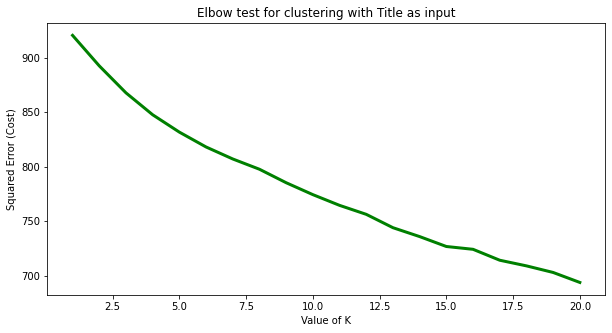

In [231]:
import matplotlib.pyplot as plt

def elbow_test(data, max_k=16, max_iter=500):
    # perform elbow test
    cost =[]
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i, max_iter=max_iter)
        kmeans.fit(data)

        # calculates squared error
        # for the clustered points
        cost.append(kmeans.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, max_k), cost, color ='g', linewidth ='3')
    plt.title("Elbow test for clustering with Title as input")
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot

elbow_test(X, max_k=21)

# PCA & KMeans

In [232]:
def make_pca_vecs(data, n_clusters=5):
# vary here the number of clusters
    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(data)
    clusters = kmeans.labels_
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=42)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(data.toarray())
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    return clusters, clusters, x0, x1

In [270]:
# assign clusters and pca vectors to our dataframe 
clusters_df, df['cluster'], df['x0'], df['x1'] = make_pca_vecs(X, n_clusters=5)

In [271]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.max_colwidth = 100

In [272]:
def get_top_keywords(this_df, data, clusters, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(data.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(df, X, clusters_df, 10)


Cluster 1
representation,representations,better,three,new,sentences,large,knowledge,towards,find

Cluster 2
features,high,sentiment,used,corpus,framework,sentence,approaches,level,learn

Cluster 3
sentences,test,used,domain,three,context,system,english,network,one

Cluster 4
metrics,find,linguistic,towards,quality,information,representation,experiments,multilingual,use

Cluster 5
test,analysis,biased,well,sentence,system,words,pre,existing,information


In [273]:
# map clusters to appropriate labels 
cluster_map = {0: "cluster 01", 
               1: "cluster 02", 
               2: "cluster 03", 
               3: "cluster 04", 
               4: "cluster 05", 
               5: "cluster 06", 
              }
# apply mapping
df['cluster'] = df['cluster'].map(cluster_map)

# visualizing outputs

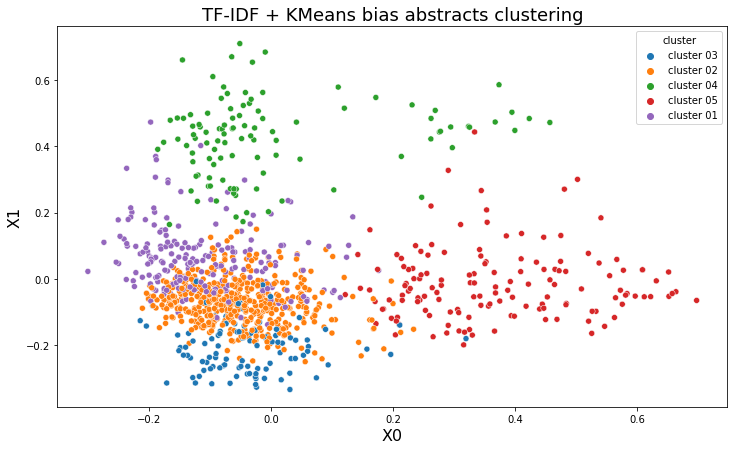

In [274]:
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns

def make_kmeans_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF + KMeans bias abstracts clustering", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='cluster')
    plt.show()
    
make_kmeans_plot(df)

# stats & plots

In [275]:
# hand crafted bias list (feel free to change)
bias_list = [' age', ' race', ' gender', ' social', ' ethnic', ' religion']

# ONE HOT ENCODING
def one_hot(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df[i] = this_df['cleaned_w_title'].str.contains(i)
        
def add_not_spec_col(this_df, bias_list=bias_list):
    for i in bias_list:
        this_df.loc[(this_df[i] == True), 'not_specified'] = False
        
    this_df.loc[(this_df['not_specified'].isnull()), 'not_specified'] = True
        
one_hot(df)
add_not_spec_col(df)

In [276]:
def count_biases(this_df, bias_list=bias_list):
    counts = []
    for i in bias_list:
        counts.append(this_df[i].value_counts())
        
    counts.append(this_df['not_specified'].value_counts())
    
    return counts

               False  True 
 age             995     44
 race           1010     29
 gender          879    160
 social          913    126
 ethnic         1027     12
 religion       1029     10
not_specified    283    756


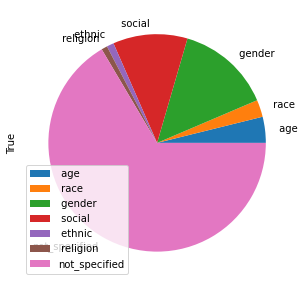

In [277]:
def plot_counts(this_df):
    df_counts = pd.concat(count_biases(this_df), axis=1).transpose()
    print(df_counts)
    df_counts.plot.pie(y=True, figsize=(5, 5));
    
plot_counts(df)

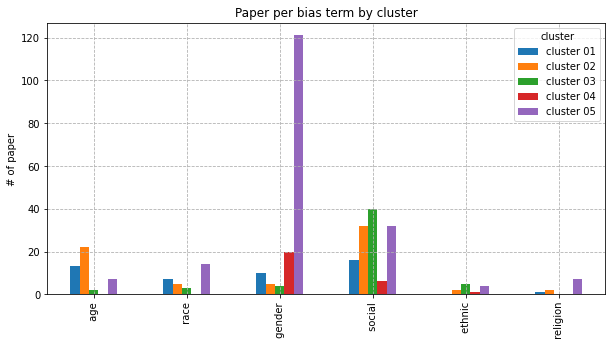

In [278]:
# cluster per bias
def clust_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['cluster']).loc[True]

    temp_df.transpose().plot.bar();
    plt.title('Paper per bias term by cluster')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

clust_per_bias_plot(df)

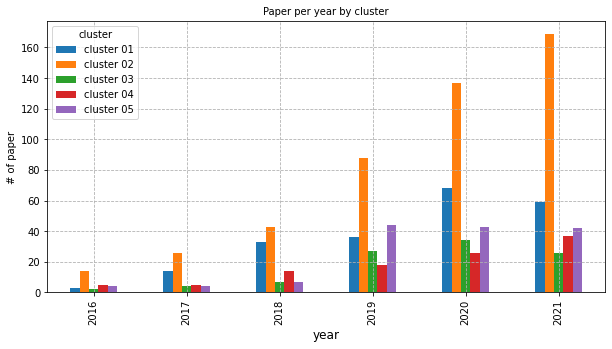

In [279]:
# year per cluster
def year_per_clust_plot(this_df):
    pd.crosstab(this_df['year'],this_df['cluster']).plot.bar();
    plt.title('Paper per year by cluster', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_clust_plot(df)

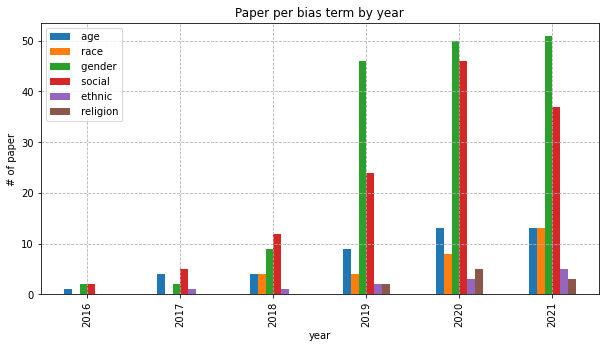

In [280]:
# bias per year
def bias_per_year_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['year']).loc[True]

    temp_df.plot.bar();
    plt.title('Paper per bias term by year')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
bias_per_year_plot(df)

In [260]:
### LDA with inspiration from here: https://medium.com/analytics-vidhya/topic-modelling-using-lda-aa11ec9bec13#:~:text=Topic%20modelling%20in%20natural%20language%20processing%20is%20a%20technique%20which,important%20to%20categories%20the%20documents.
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(this_df, col, range_min=1, range_max=3, mindf=0.01, maxdf=0.5):
    
    """Returns the count vectorized dataframe based on the arguments
    
    param df(dataframe): dataframe containing the values
    param  d(str): the column name, under which the documents are present
    param range_min(int): smallest n of n-gram wanted
    param range_max(int): largest n of n-gram wanted
    param mindf(int): threshold for common words
    param maxdf(int): threshold for rare words
    
    return cv(CountVectorizer): the count vectorizer
           cv_df(dataframe): dataframe containing the bag of words"""
    
    vectorizer = CountVectorizer(ngram_range=(range_min, range_max), min_df=mindf, max_df=maxdf)
    Z = vectorizer.fit_transform(this_df[col])
    new_df = pd.DataFrame(Z.toarray(), columns = vectorizer.get_feature_names())
    
    return Z, new_df, vectorizer

Z_df, _, cv_df = get_bow(df, 'cleaned_w_title')


In [284]:
# Use LDA to look for 6 topics
from sklearn.decomposition import LatentDirichletAllocation

def make_lda(this_df, Z, vectorizer, n_topics=6, n_words=10):
    model_lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    model_lda.fit(Z)

    feature_names = vectorizer.get_feature_names()

    topic_list = []
    for topic_idx, topic in enumerate(model_lda.components_):
        top_n = [feature_names[i]
                  for i in topic.argsort()
                   [-n_words:]][::-1]

        top_features = ' '.join(top_n)

        topic_list.append(f"topic_{'_'.join(top_n[:3])}") 

        print(f"Topic {topic_idx}:\n{top_features}")
        print('\n')

    topic_result = model_lda.transform(Z)
    this_df['topic']  = topic_result.argmax(axis=1)
    
make_lda(df, Z_df, cv_df, n_topics=5)

Topic 0:
language model training learning data performance tasks show based trained


Topic 1:
gender word embeddings biases gender bias word embeddings social language methods embedding


Topic 2:
translation neural machine translation machine model based show generation summarization neural machine


Topic 3:
evaluation question human dataset systems data language based answering metrics


Topic 4:
language data news task detection based dataset corpus systems paper




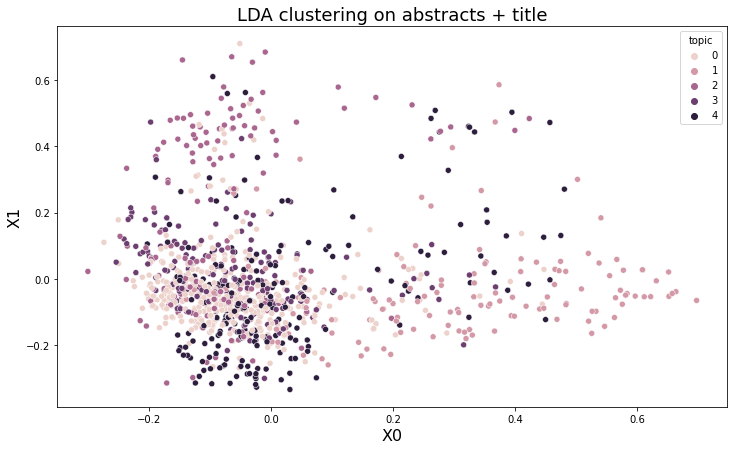

In [289]:
def make_lda_plot(this_df):
    # set image size
    plt.figure(figsize=(12, 7))
    plt.title("LDA clustering on abstracts + title", fontdict={"fontsize": 18})
    # set axes names
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    # create scatter plot with seaborn, where hue is the class used to group the data
    sns.scatterplot(data=this_df, x='x0', y='x1', hue='topic')
    plt.show()
    
make_lda_plot(df)

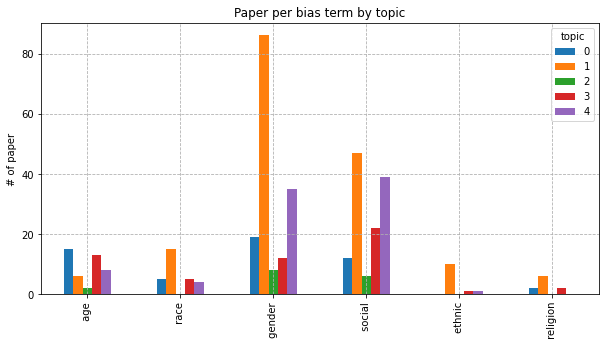

In [286]:
# topic per bias
def topic_per_bias_plot(this_df, bias_list=bias_list):
    temp_df = pd.DataFrame()

    for i in bias_list:
        temp_df[i] = pd.crosstab(this_df[i],this_df['topic']).loc[True]

    temp_df.transpose().plot.bar();
    plt.title('Paper per bias term by topic')
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')

topic_per_bias_plot(df)

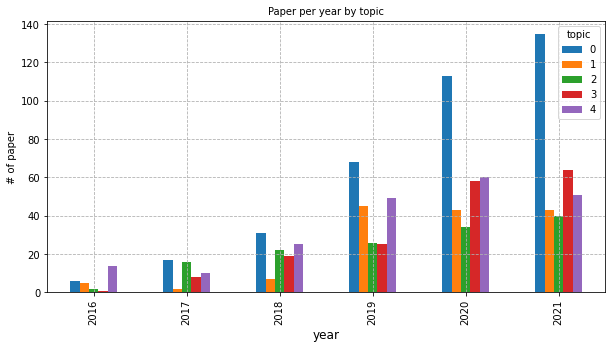

In [285]:
# year per topic
def year_per_topic_plot(this_df):
    pd.crosstab(this_df['year'],this_df['topic']).plot.bar();
    plt.title('Paper per year by topic', fontdict={"fontsize": 10})
    plt.xlabel("year", fontdict={"fontsize": 12})
    plt.ylabel("# of paper")
    plt.grid(linestyle='--')
    
year_per_topic_plot(df)

In [298]:
# TODO
# how do cluster correspond to topic
df_ws = df[df['booktitle'].str.contains('Workshop', na=False)]
df_co = df[df['booktitle'].str.contains('Conference', na=False)]

def main(this_df, data, n_cluster=6, max_words=20, bias_list=bias_list, run_stats=True):
    # length of dataframe
    print(f'entries: {len(this_df.index)}')
    
    # create cluster & pca components & print keywords for cluster
    cluster, this_df['cluster'], this_df['x0'], this_df['x1'] = make_pca_vecs(data, n_cluster)
    get_top_keywords(this_df, data, cluster, max_words)
    this_df['cluster'] = this_df['cluster'].map(cluster_map)
    
    # create kmeans plot
    make_kmeans_plot(this_df)
    #elbow_test(data)
    
    # do one hot encoding & create stats plots
    if run_stats:
        one_hot(this_df)
        plot_counts(this_df)
        clust_per_bias_plot(this_df, bias_list)
        bias_per_year_plot(this_df, bias_list)
    
    year_per_clust_plot(this_df)
    
    # create lda vectorizer & perform LDA
    Z_df, _, cv_df = get_bow(this_df, 'cleaned_w_title')
    make_lda(this_df, Z_df, cv_df, n_topics=n_cluster)
    make_lda_plot(df)
    
    # stats of LDA
    if run_stats:
        topic_per_bias_plot(df)
        
    year_per_topic_plot(df)

In [299]:
pd.options.mode.chained_assignment = None  # default='warn'
# create vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2, max_features=80)

entries: 279

Cluster 1
level,may,proposed,biased,approach,corpora,provide,training,test,languages,method,english,system,methods,research,many,nlp,translation,processing,machine

Cluster 2
methods,study,proposed,approach,trained,one,research,experiments,classification,present,bert,network,two,features,accuracy,system,biased,media,detection,news

Cluster 3
state,art,domain,set,existing,method,knowledge,user,well,study,recent,datasets,approach,system,question,two,end,human,generation,evaluation

Cluster 4
semantic,set,fine,representation,approach,new,training,find,sentiment,corpus,trained,present,classification,linguistic,annotated,features,datasets,tasks,bert,information

Cluster 5
specific,state,method,trained,training,present,across,words,large,corpora,studies,recent,methods,debiasing,user,study,embedding,media,social,embeddings


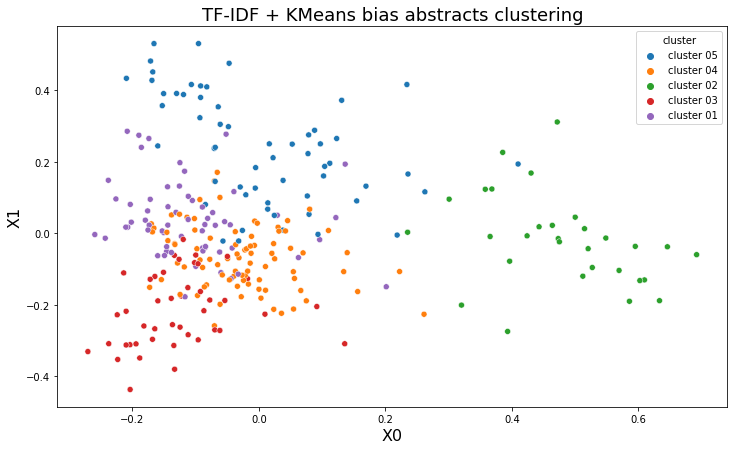

               False  True 
 age             269     10
 race            273      6
 gender          216     63
 social          226     53
 ethnic          275      4
 religion        276      3
not_specified    106    173
Topic 0:
gender language data embeddings word nlp natural gender bias natural language research


Topic 1:
gender biases models language social gender bias media word analysis data


Topic 2:
models language word dataset based gender biases bert embeddings data


Topic 3:
model task news based system data learning models neural using


Topic 4:
text language generation model clinical evaluation using systems models data




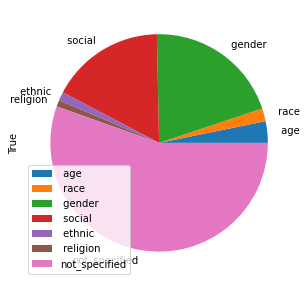

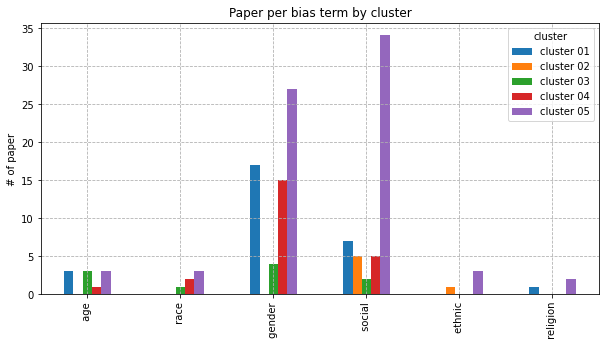

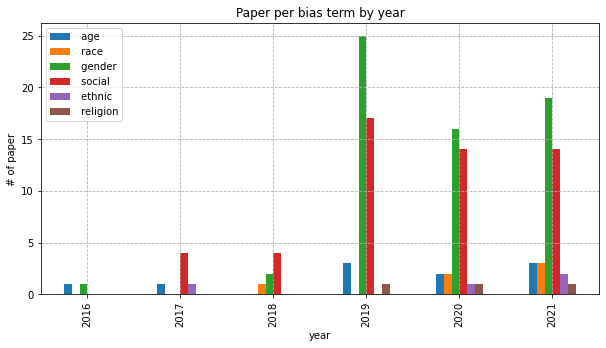

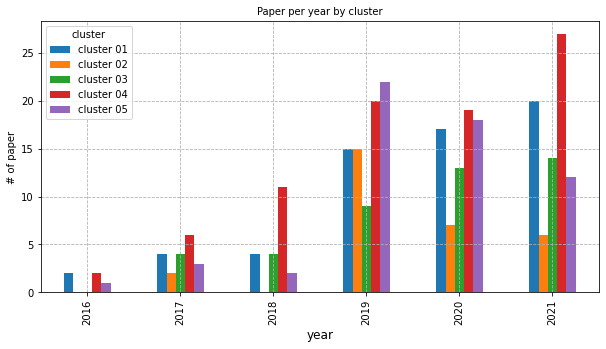

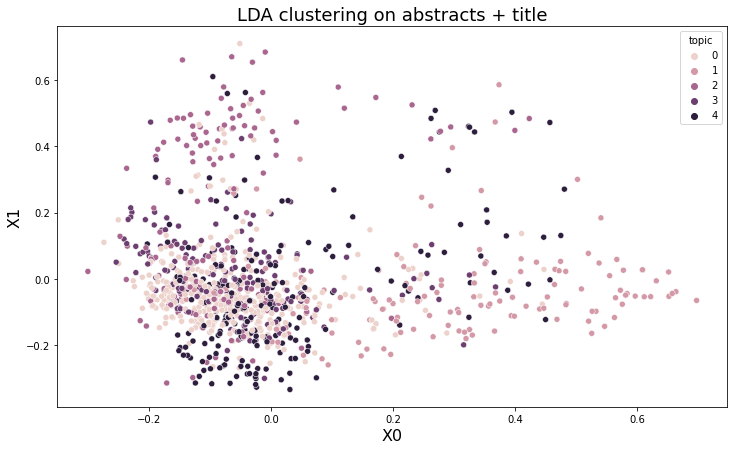

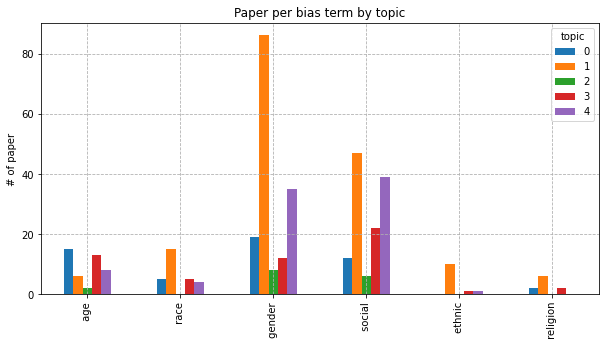

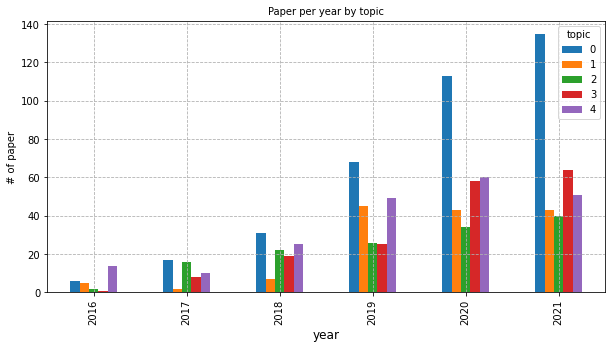

In [300]:
# ONLY LOOK AT WORKSHOP PAPERS
data1 = vectorizer.fit_transform(df_ws['cleaned_w_title'])
main(df_ws, data1, n_cluster=5)

entries: 558

Cluster 1
multiple,improve,study,test,analysis,sentences,novel,often,evaluation,use,system,large,new,research,english,first,corpus,systems,detection,news

Cluster 2
pre,systems,corpora,new,proposed,study,nlp,biased,languages,analysis,across,english,use,words,find,corpus,representations,social,embeddings,gender

Cluster 3
generation,use,metrics,proposed,multi,well,approach,sentences,sentence,inference,attention,level,evaluation,problem,systems,quality,sequence,english,machine,translation

Cluster 4
across,find,corpus,one,set,study,use,inference,languages,entity,experiments,knowledge,representations,nlp,new,large,approach,natural,existing,classification

Cluster 5
level,may,system,learn,proposed,previous,set,test,systems,analysis,sequence,framework,knowledge,semantic,natural,automatic,metrics,evaluation,generation,question


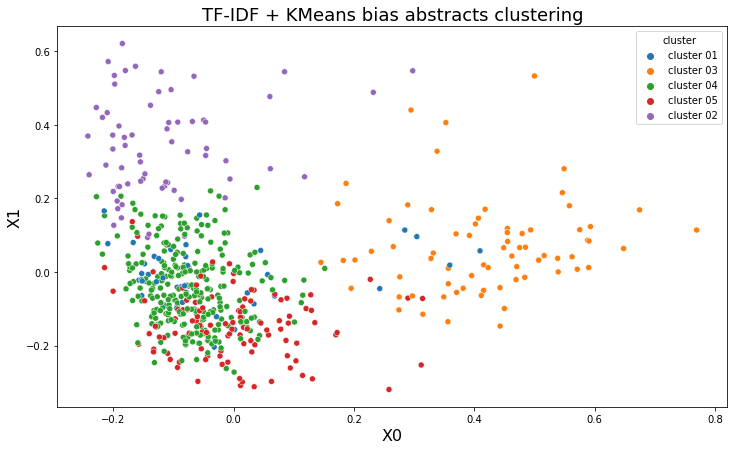

               False  True 
 age             533     25
 race            539     19
 gender          488     70
 social          505     53
 ethnic          553      5
 religion        554      4
not_specified    127    431
Topic 0:
gender word language biases embeddings gender bias task word embeddings text methods


Topic 1:
language model data learning performance tasks natural neural training language models


Topic 2:
news based dataset corpus detection different sentiment analysis media user


Topic 3:
translation machine machine translation model training neural evaluation based quality systems


Topic 4:
model data training text question propose learning entity performance method




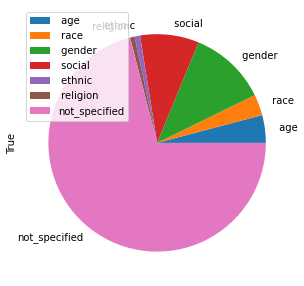

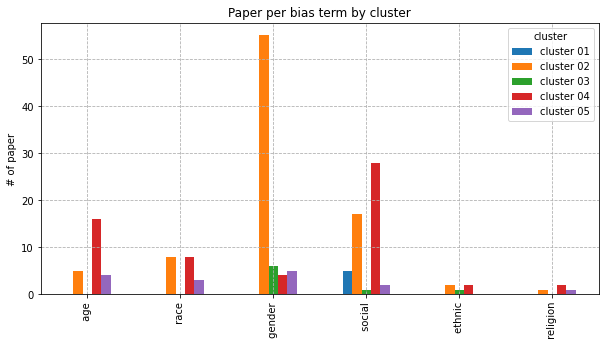

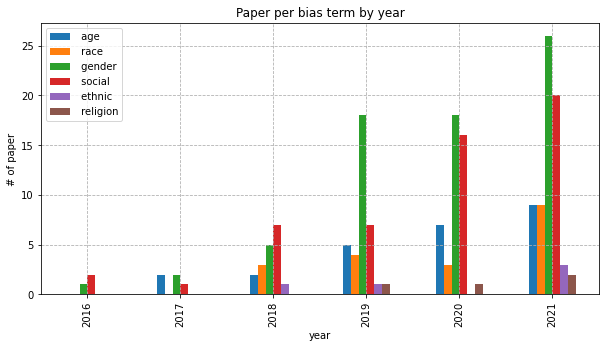

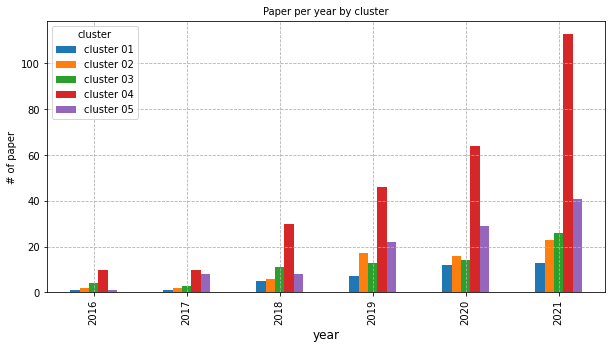

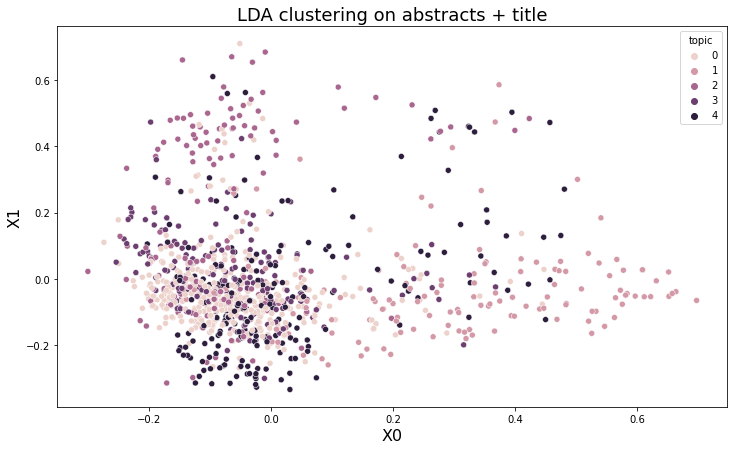

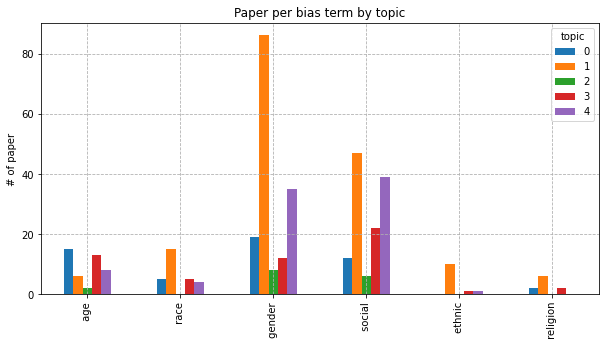

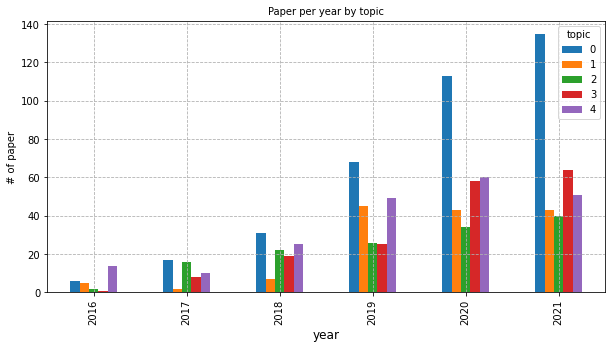

In [301]:
# ONLY LOOK AT CONFERENCE PAPERS
data2 = vectorizer.fit_transform(df_co['cleaned_w_title'])
main(df_co, data2, n_cluster=5)

entries: 119

Cluster 1
level,studies,find,often,non,world,users,approaches,like,use,introduce,may,learning,multiple,classification,new,training,datasets,groups,demographic

Cluster 2
two,translation,existing,context,often,english,tasks,large,training,proposed,evaluate,languages,measure,one,find,method,stereotypes,representations,corpora,embedding

Cluster 3
often,problem,measure,first,applications,annotated,learning,recent,various,translation,machine,approach,knowledge,automatic,user,evaluation,system,processing,natural,systems

Cluster 4
neural,natural,including,users,tasks,specific,user,test,existing,datasets,performance,discourse,content,detection,political,level,fake,sentence,articles,news

Cluster 5
scale,learning,system,specific,annotated,various,well,focus,english,first,automatic,two,large,recent,neural,set,use,sentiment,tweets,towards


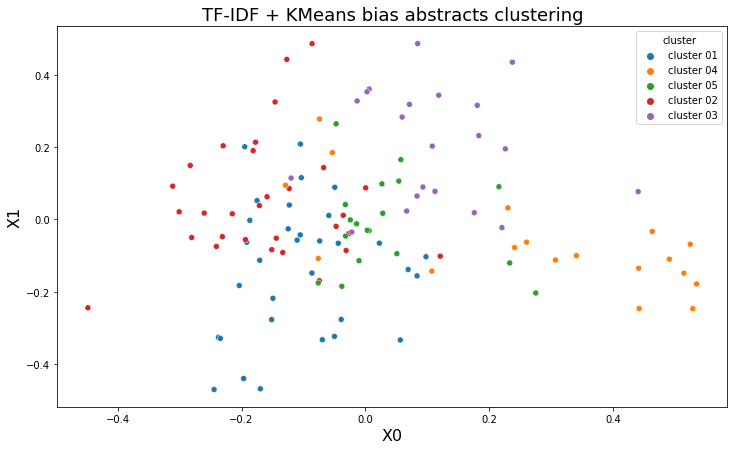

               False  True 
 age           113.0    6.0
 race          109.0   10.0
 gender         79.0   40.0
 social          NaN  119.0
 ethnic        112.0    7.0
 religion      116.0    3.0
not_specified  119.0    NaN
Topic 0:
embeddings word biases gender word embeddings gender bias models language methods social biases


Topic 1:
language models data different political used media emotion work based


Topic 2:
gender data models model biases language social media media text based


Topic 3:
data nlp systems language commonsense research based processing word models


Topic 4:
news media social media detection fake dataset task model fake news based




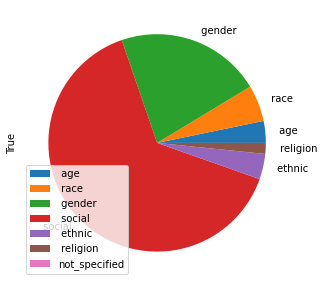

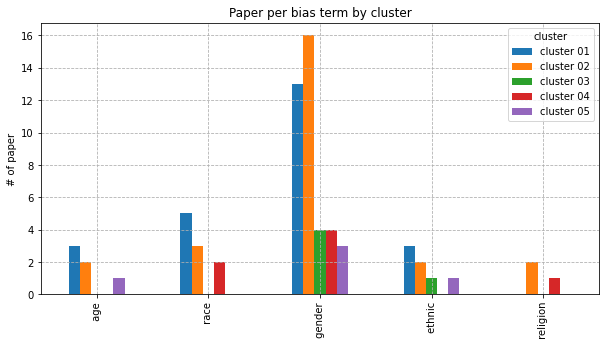

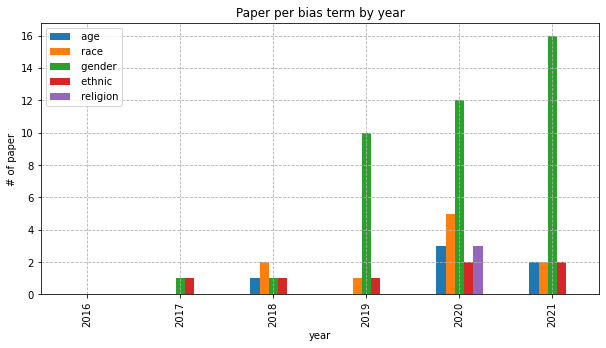

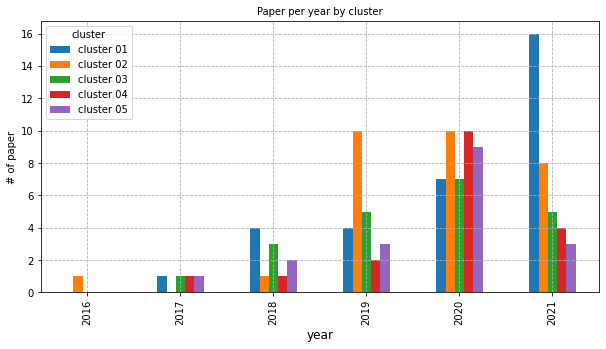

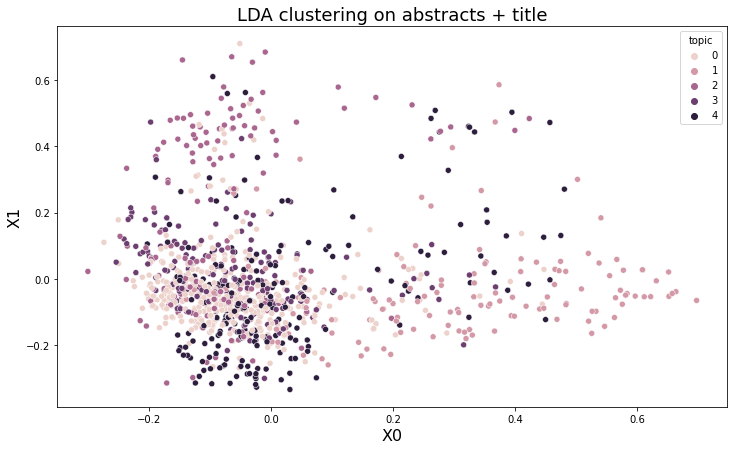

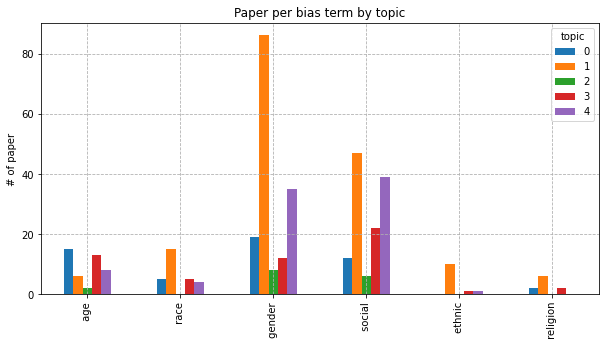

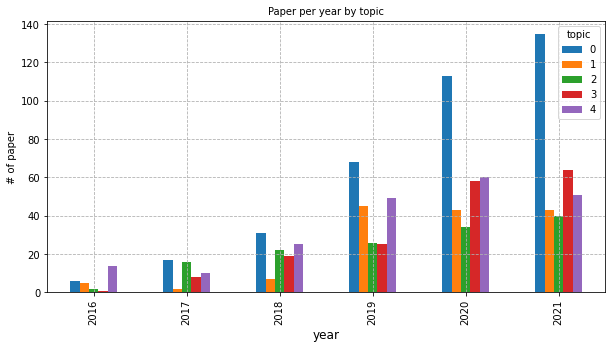

In [302]:
# ONLY LOOK AT PAPERS CONTAINING "SOCIAL"
df_social = df[df['abstract'].str.contains('social', na=False)]
data_social = vectorizer.fit_transform(df_social['cleaned_w_title'])
bias_list_social = [' age', ' race', ' gender', ' ethnic', ' religion']
main(df_social, data_social, n_cluster=5, bias_list=bias_list_social)

entries: 756

Cluster 1
network,new,biased,features,well,representations,linguistic,corpus,present,sentiment,embeddings,analysis,languages,use,words,information,classification,detection,word,news

Cluster 2
new,large,experiments,proposed,used,semantic,problem,trained,set,better,inference,existing,entity,framework,human,generation,systems,question,knowledge,natural

Cluster 3
well,multilingual,one,use,trained,proposed,level,languages,used,metrics,human,word,problem,transformer,systems,sequence,quality,english,machine,translation


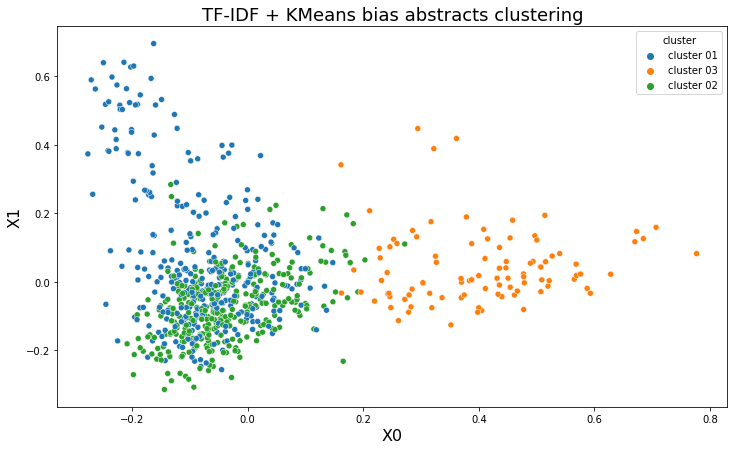

Topic 0:
model translation training language neural word show learning knowledge based


Topic 1:
language data model performance based entity languages task neural training


Topic 2:
text data evaluation based model language human generation news dataset




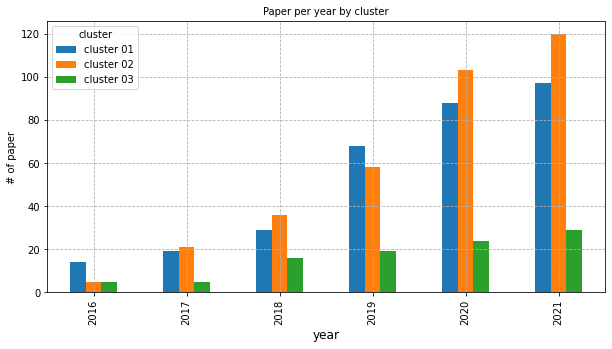

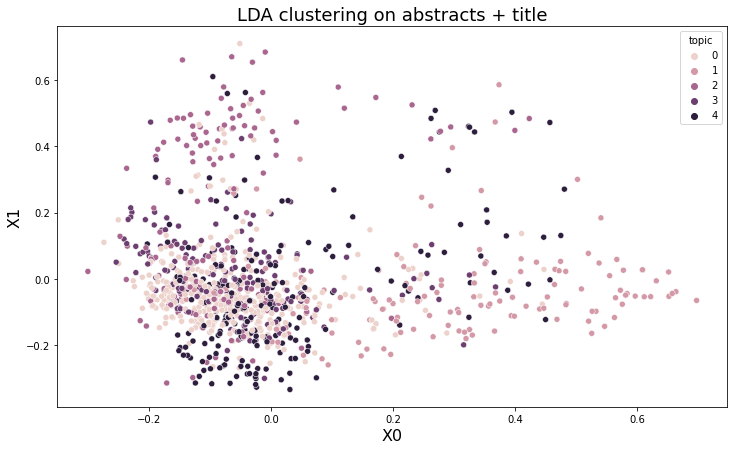

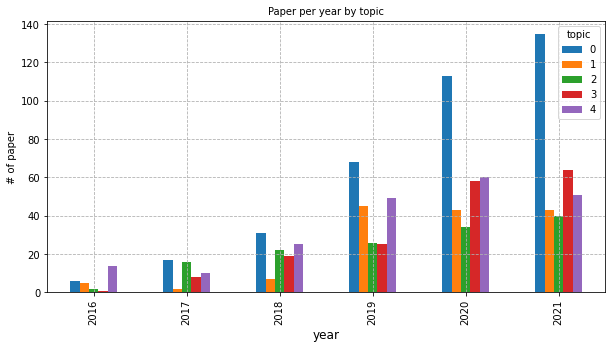

In [303]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 3 CLUSTER
df_unspec = df[df['not_specified'] == True]
data_unspec = vectorizer.fit_transform(df_unspec['cleaned_w_title'])
main(df_unspec, data_unspec, n_cluster=3, run_stats = False)

entries: 756

Cluster 1
use,well,system,multilingual,languages,trained,proposed,level,used,metrics,word,problem,transformer,human,sequence,systems,quality,english,machine,translation

Cluster 2
framework,systems,large,present,set,question,generation,experiments,used,existing,trained,use,human,news,new,analysis,word,knowledge,information,natural


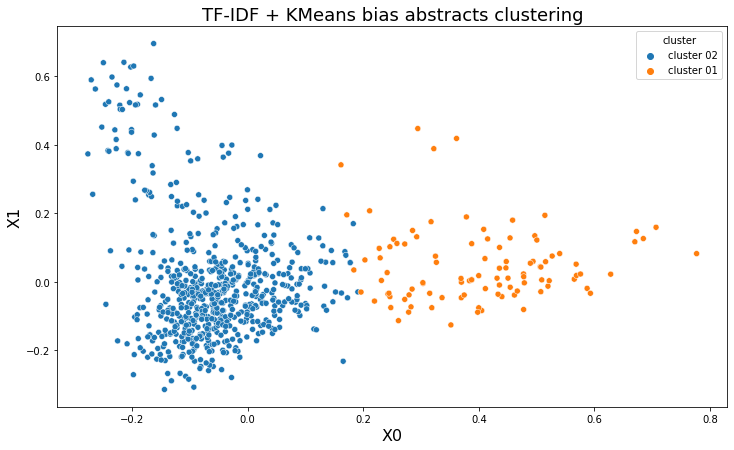

Topic 0:
model training translation based text show neural language generation machine


Topic 1:
language data model based performance task learning news word biases




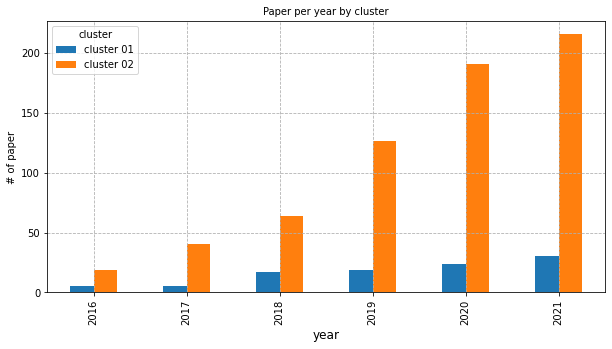

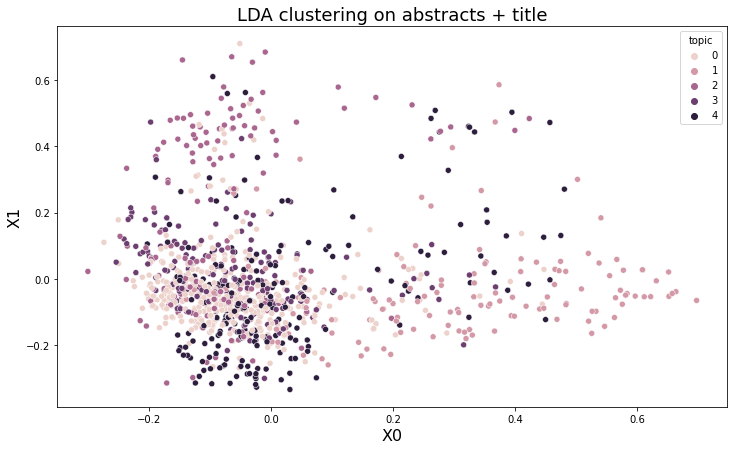

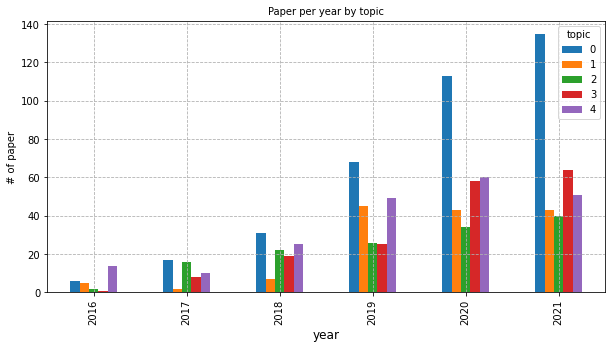

In [304]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 2 CLUSTER
main(df_unspec, data_unspec, n_cluster=2, run_stats = False)

entries: 756

Cluster 1
sentences,metrics,use,domain,trained,well,word,inference,languages,multilingual,level,proposed,transformer,problem,systems,sequence,quality,english,machine,translation

Cluster 2
recent,level,semantic,study,well,research,use,existing,problem,framework,used,quality,natural,question,system,automatic,metrics,human,systems,generation

Cluster 3
bert,linguistic,corpus,novel,existing,one,large,english,nlp,used,well,analysis,information,semantic,present,words,languages,representations,embeddings,word

Cluster 4
sentence,research,question,corpus,existing,better,find,inference,framework,experiments,set,large,new,nlp,use,trained,analysis,information,classification,natural

Cluster 5
study,large,novel,test,inference,human,trained,problem,learn,find,question,better,prediction,information,experiments,new,existing,systems,entity,knowledge

Cluster 6
new,trained,set,one,bert,research,used,analysis,use,present,first,corpus,study,information,features,summarization,biased,system,

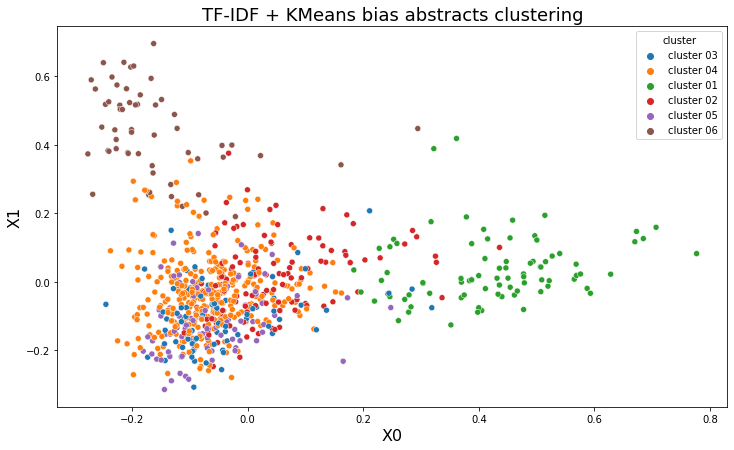

Topic 0:
model language biases natural training datasets natural language learning performance dataset


Topic 1:
entity task model data performance language relation tasks entities learning


Topic 2:
text language generation model data learning tasks biases nlp propose


Topic 3:
translation model neural language machine machine translation training based transformer word


Topic 4:
language data dataset knowledge work sentiment analysis datasets results performance


Topic 5:
news data based dataset systems human different system evaluation summarization




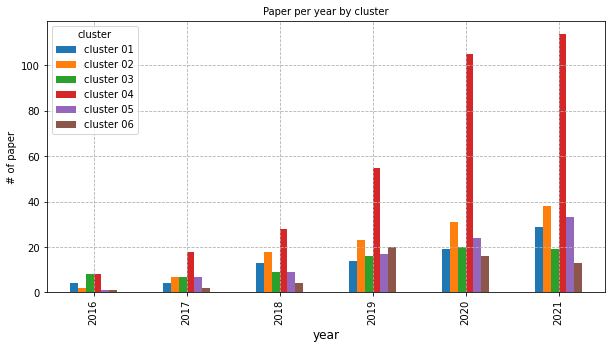

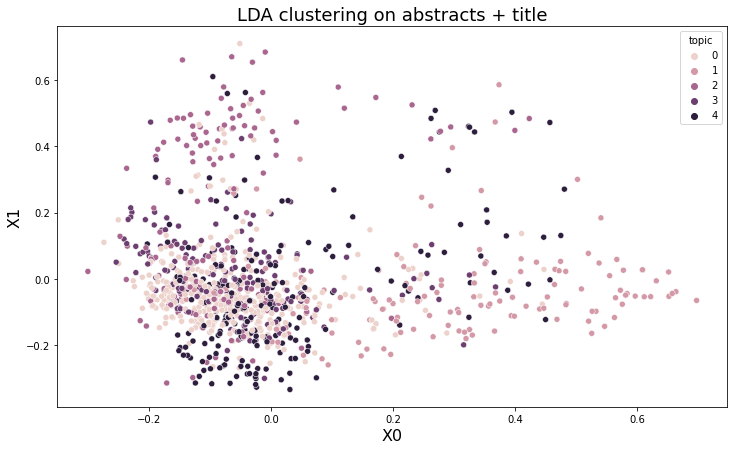

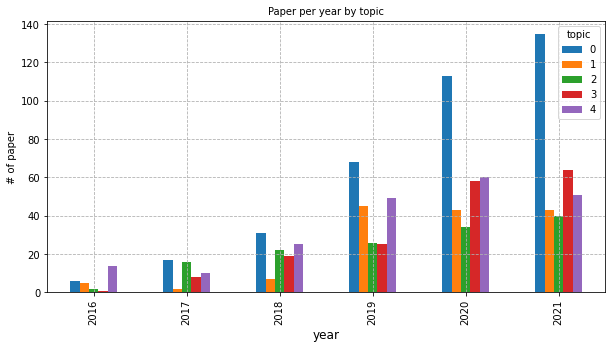

In [305]:
# ONLY LOOK AT PAPERS THAT DON'T SPECIFY A BIAS - 6 CLUSTER
main(df_unspec, data_unspec, n_cluster=6, run_stats = False)